In [0]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.resnet50 import ResNet50

In [0]:
!gdown https://drive.google.com/uc?id=1xs6edsDRb5ktm8BMPJb-GtKOXxFqiJKv
!unzip seed_dataset.zip 

In [0]:
def focal_loss(gamma=2., alpha=2):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
	return focal_loss_fixed

In [37]:
tf.random.set_seed(999)
img_size = 128

base_model = Xception(input_shape=(img_size, img_size,3), weights='imagenet',include_top=False)

base_model.trainable = True

classifier = Sequential([GlobalAveragePooling2D(),
                         Dense(512, activation='relu'),
                         Dropout(0.5),
                         Dense(256, activation='relu'),
                         Dropout(0.5),
                         Dense(3, activation='softmax')])

model = Sequential()
model.add(base_model)
model.add(classifier)
model.compile(optimizer= Adam(lr = 0.0001) ,loss=focal_loss(alpha = 2),metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 4, 4, 2048)        20861480  
_________________________________________________________________
sequential_8 (Sequential)    (None, 3)                 1181187   
Total params: 22,042,667
Trainable params: 21,988,139
Non-trainable params: 54,528
_________________________________________________________________


In [38]:
tf.random.set_seed(999)

train_datagen = ImageDataGenerator(brightness_range = (0.2,1),
                                   rescale = 1./255,
                                   rotation_range=90,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   fill_mode='constant')

training_path = '/content/seed_dataset/train'
training_set = train_datagen.flow_from_directory(training_path,
                                                 target_size = (img_size, img_size),
                                                 batch_size = 32,
                                                 class_mode='categorical')

# valid_set = train_datagen.flow_from_directory(training_path,
#                                             target_size = (img_size, img_size),
#                                             batch_size = 512,
#                                             class_mode='categorical',
#                                             subset = 'validation',
#                                             shuffle = False)

test_datagen = ImageDataGenerator(rescale = 1./255)

test_path = '/content/seed_dataset/test'
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (img_size, img_size),
                                            batch_size = 512,
                                            shuffle = False,
                                            class_mode='categorical')

Found 10982 images belonging to 3 classes.
Found 2748 images belonging to 3 classes.


In [0]:
EPOCHS = 1000
checkpoint_filepath = '/content/checkpoint/xception'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

early_stop = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [0]:
h = model.fit(training_set,
                    steps_per_epoch = training_set.n // training_set.batch_size,
                    epochs = EPOCHS,
                    validation_data = valid_set,
                    validation_steps = valid_set.n // valid_set.batch_size,
                    callbacks=[model_checkpoint_callback, early_stop] )

Epoch 1/1000
274/274 [==============================] - 68s 250ms/step - loss: 0.0318 - accuracy: 0.9017 - val_loss: 0.0581 - val_accuracy: 0.8695
Epoch 2/1000
274/274 [==============================] - 67s 245ms/step - loss: 0.0142 - accuracy: 0.9471 - val_loss: 0.0325 - val_accuracy: 0.9476
Epoch 3/1000
274/274 [==============================] - 67s 246ms/step - loss: 0.0140 - accuracy: 0.9548 - val_loss: 0.0358 - val_accuracy: 0.9522
Epoch 4/1000
274/274 [==============================] - 67s 243ms/step - loss: 0.0102 - accuracy: 0.9689 - val_loss: 0.0093 - val_accuracy: 0.9752
Epoch 5/1000
274/274 [==============================] - 66s 240ms/step - loss: 0.0070 - accuracy: 0.9783 - val_loss: 0.0103 - val_accuracy: 0.9724
Epoch 6/1000
274/274 [==============================] - 67s 245ms/step - loss: 0.0104 - accuracy: 0.9668 - val_loss: 0.0240 - val_accuracy: 0.9085
Epoch 7/1000
274/274 [==============================] - 67s 244ms/step - loss: 0.0090 - accuracy: 0.9732 - val_loss: 0

KeyboardInterrupt: ignored

In [40]:
h2 = model.fit(training_set,
                    steps_per_epoch = training_set.n // training_set.batch_size,
                    epochs = EPOCHS,
                    validation_data = test_set,
                    validation_steps = test_set.n // test_set.batch_size,
                    callbacks=[model_checkpoint_callback, early_stop] )

Epoch 1/1000
343/343 [==============================] - 87s 252ms/step - loss: 0.0524 - accuracy: 0.8717 - val_loss: 0.0171 - val_accuracy: 0.9613
Epoch 2/1000
343/343 [==============================] - 87s 252ms/step - loss: 0.0133 - accuracy: 0.9616 - val_loss: 0.0096 - val_accuracy: 0.9766
Epoch 3/1000
343/343 [==============================] - 87s 252ms/step - loss: 0.0088 - accuracy: 0.9754 - val_loss: 0.0059 - val_accuracy: 0.9848
Epoch 4/1000
343/343 [==============================] - 87s 253ms/step - loss: 0.0076 - accuracy: 0.9784 - val_loss: 0.0053 - val_accuracy: 0.9832
Epoch 5/1000
343/343 [==============================] - 86s 251ms/step - loss: 0.0063 - accuracy: 0.9843 - val_loss: 0.0057 - val_accuracy: 0.9883
Epoch 6/1000
343/343 [==============================] - 86s 251ms/step - loss: 0.0054 - accuracy: 0.9836 - val_loss: 0.0082 - val_accuracy: 0.9859
Epoch 7/1000
343/343 [==============================] - 86s 252ms/step - loss: 0.0048 - accuracy: 0.9858 - val_loss: 0

In [0]:
model_2 = keras.models.load_model('/content/drive/My Drive/Xception_book_2.h5', compile = False)
model.compile(optimizer= Adam(lr = 0.0001) ,loss=focal_loss(alpha = 2),metrics=['accuracy'])

In [41]:
score = model.evaluate(training_set, verbose = 1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

344/344 [==============================] - 51s 147ms/step - loss: 0.0023 - accuracy: 0.9922
Test loss: 0.002305768197402358
Test accuracy: 0.9921690225601196


In [42]:
score = model.evaluate(test_set, verbose = 1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

6/6 [==============================] - 3s 536ms/step - loss: 0.0043 - accuracy: 0.9858
Test loss: 0.004348525777459145
Test accuracy: 0.9858078360557556


In [29]:
score = model.evaluate(training_set, verbose = 1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

275/275 [==============================] - 40s 147ms/step - loss: 0.0021 - accuracy: 0.9934
Test loss: 0.00210363557562232
Test accuracy: 0.9933993220329285


In [30]:
score = model.evaluate(test_set, verbose = 1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

6/6 [==============================] - 3s 536ms/step - loss: 0.0039 - accuracy: 0.9905
Test loss: 0.0038929616566747427
Test accuracy: 0.9905385971069336


In [21]:
score = model.evaluate(training_set, verbose = 1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

275/275 [==============================] - 41s 148ms/step - loss: 0.0044 - accuracy: 0.9840
Test loss: 0.004366581793874502
Test accuracy: 0.983953595161438


In [22]:
score = model.evaluate(test_set, verbose = 1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

6/6 [==============================] - 4s 733ms/step - loss: 0.0050 - accuracy: 0.9840
Test loss: 0.005019572097808123
Test accuracy: 0.983988344669342


In [0]:
filepath = '/content/checkpoint/'
latest = tf.train.latest_checkpoint(filepath)
print(latest)
model.load_weights(latest)

/content/checkpoint/xception


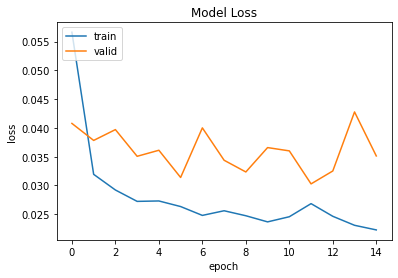

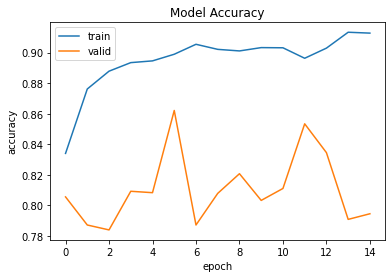

In [0]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch') 
plt.legend(['train','valid'], loc='upper left')
plt.show()

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
Y_pred = model.predict_generator(valid_set, valid_set.n // valid_set.batch_size + 1, verbose = 1)
y_pred = np.argmax(Y_pred, axis=1)

5/5 [==============================] - 7s 1s/step


In [0]:
print(confusion_matrix(valid_set.classes, y_pred))

[[1189    0    9]
 [   0   88    2]
 [  26    2  879]]


In [31]:
Y_pred = model.predict_generator(test_set,  test_set.n // test_set.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

Instructions for updating:
Please use Model.predict, which supports generators.


In [34]:
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))
print('Classification Report')
print(classification_report(test_set.classes, y_pred, target_names=None))

Confusion Matrix
[[1490    0    9]
 [   0  113    2]
 [   8    7 1119]]
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1499
           1       0.94      0.98      0.96       115
           2       0.99      0.99      0.99      1134

    accuracy                           0.99      2748
   macro avg       0.98      0.99      0.98      2748
weighted avg       0.99      0.99      0.99      2748



In [0]:
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))
print('Classification Report')
print(classification_report(test_set.classes, y_pred, target_names=None))

Confusion Matrix
[[1486    0   13]
 [   0  111    4]
 [   9    7 1118]]
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1499
           1       0.94      0.97      0.95       115
           2       0.99      0.99      0.99      1134

    accuracy                           0.99      2748
   macro avg       0.97      0.98      0.98      2748
weighted avg       0.99      0.99      0.99      2748



In [35]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
model.save('/content/drive/My Drive/Xception_book_2.h5')

In [49]:
print(test_set.class_indices)
class_name = {v:k for k, v in test_set.class_indices.items()}
print(class_name)

{'neg': 0, 'none': 1, 'pos': 2}
{0: 'neg', 1: 'none', 2: 'pos'}


In [47]:
i = 0
data_n = 0
correct = 0
wrong = []
while i <= 5:
  data, lab = next(test_set)
  data_n += data.shape[0]
  y_hat = model.predict(data)
  actual_class = lab.argmax(axis=-1)
  predict_class = y_hat.argmax(axis=-1)
  wrong_index = tf.where(actual_class != predict_class)[:,0]
  for j in wrong_index:
    wrong.append((data[j], actual_class[j], predict_class[j]))
  correct += np.sum(y_hat.argmax(axis=-1) == lab.argmax(axis=-1))
  i += 1
  
print(data_n, correct)

2748 2709


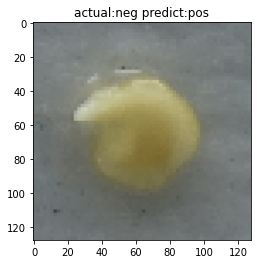

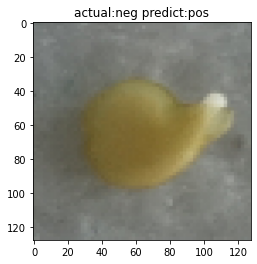

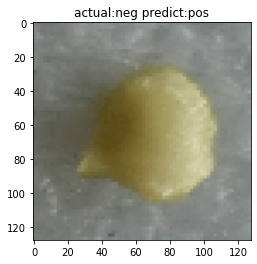

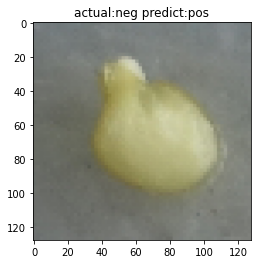

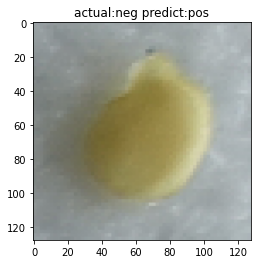

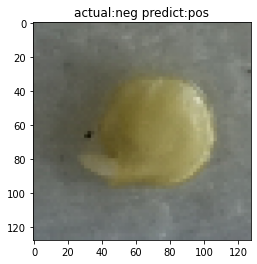

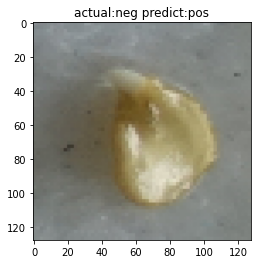

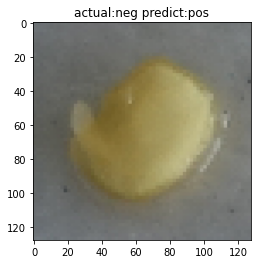

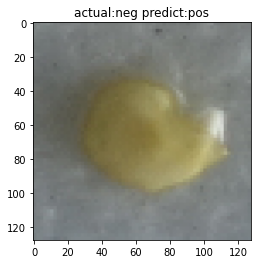

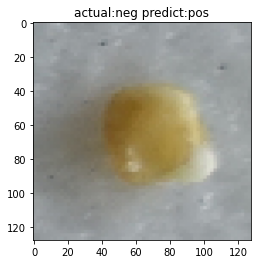

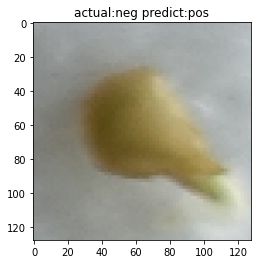

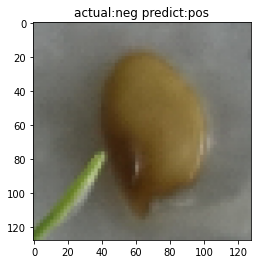

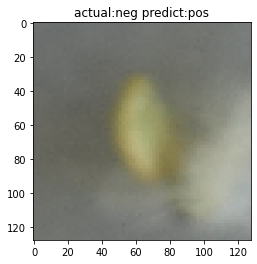

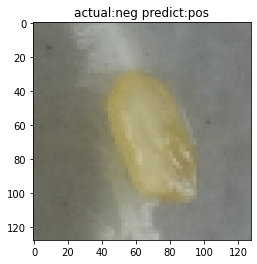

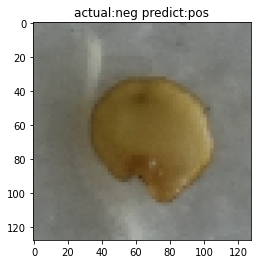

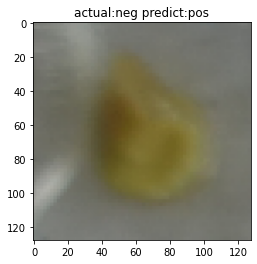

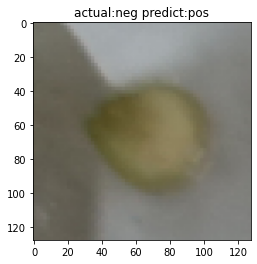

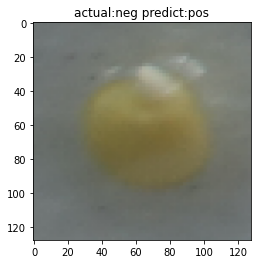

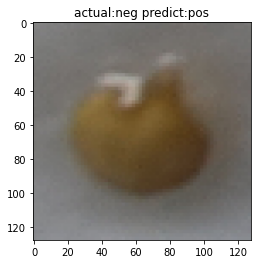

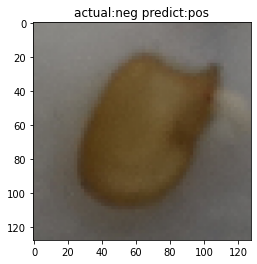

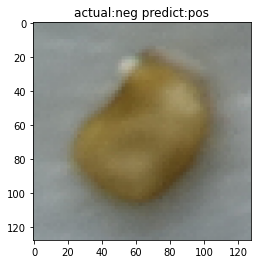

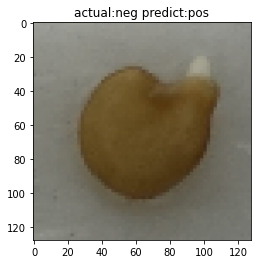

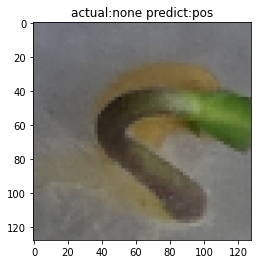

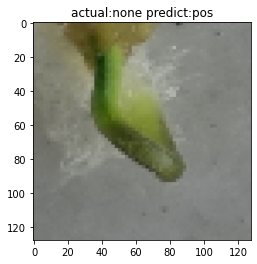

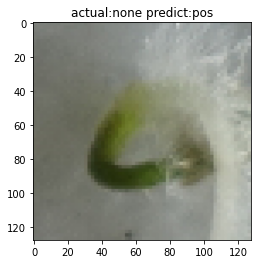

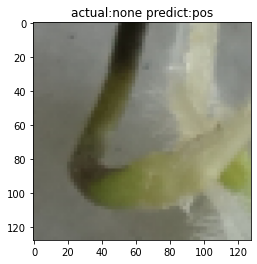

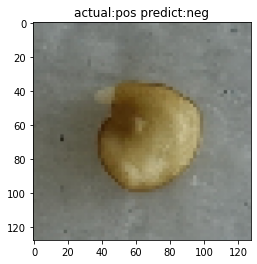

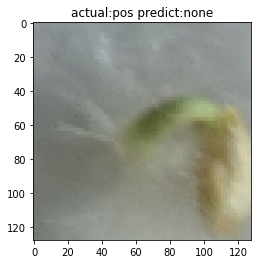

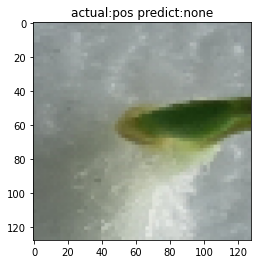

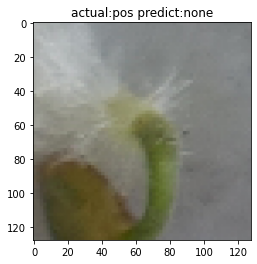

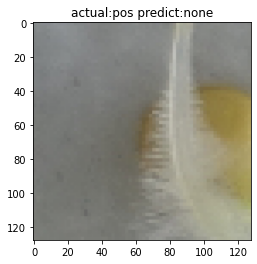

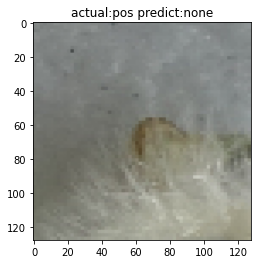

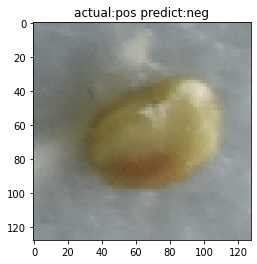

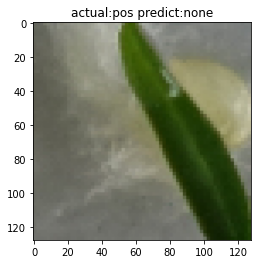

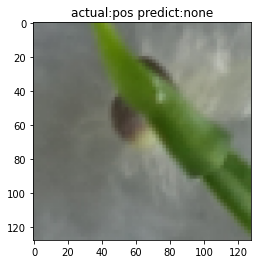

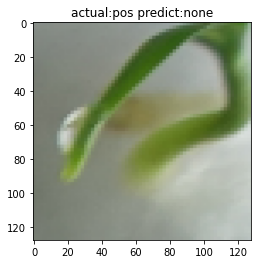

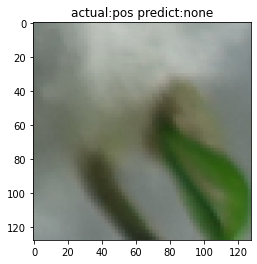

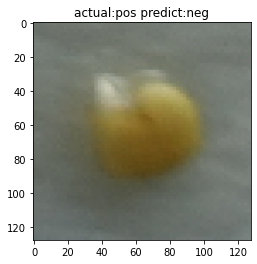

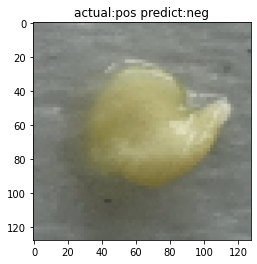

In [50]:
for data, ac, pr in wrong:
  plt.imshow(data)
  plt.title(f'actual:{class_name[ac]} predict:{class_name[pr]}')
  plt.show()

pos 

neg 

----------------------------------

none 

clssify as: 1 [[0.002119   0.5677235  0.43015748]]


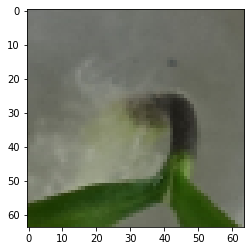

clssify as: 1 [[0.00258442 0.5540767  0.4433389 ]]


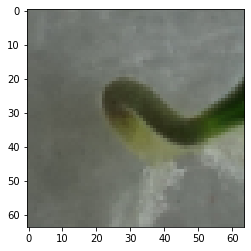

clssify as: 1 [[0.00220943 0.57112086 0.42666972]]


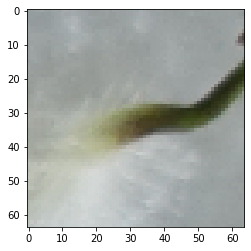

clssify as: 1 [[0.00179517 0.58671707 0.41148785]]


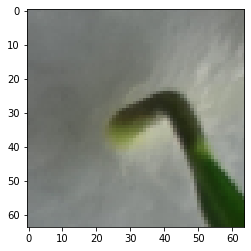

clssify as: 1 [[0.002982  0.5990824 0.3979356]]


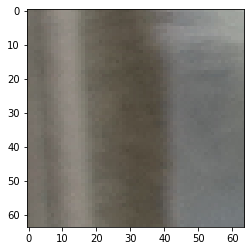

clssify as: 1 [[0.00224486 0.59052444 0.4072307 ]]


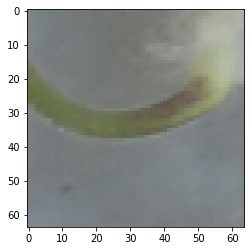

clssify as: 1 [[0.00204197 0.58438504 0.41357297]]


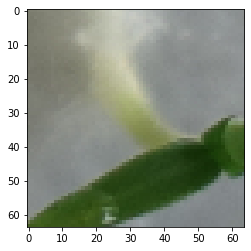

clssify as: 1 [[0.00265852 0.5370852  0.46025628]]


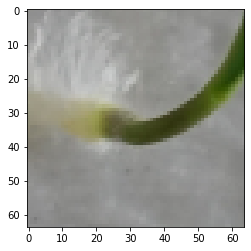

clssify as: 1 [[0.00237486 0.6007296  0.3968955 ]]


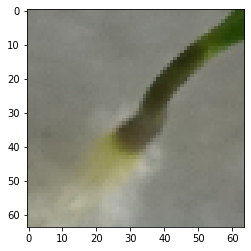

clssify as: 1 [[0.00313251 0.5809526  0.41591486]]


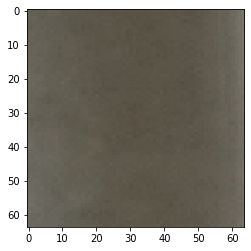

clssify as: 1 [[0.00282413 0.51606953 0.4811063 ]]


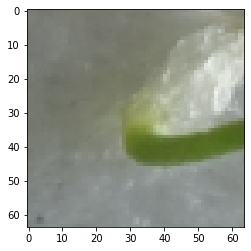

clssify as: 1 [[0.00201806 0.56950045 0.42848152]]


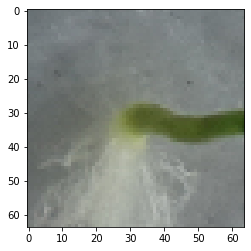

clssify as: 1 [[0.00229697 0.53995633 0.4577467 ]]


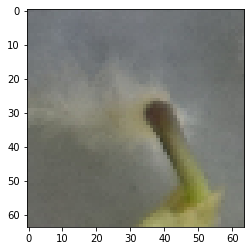

clssify as: 1 [[0.00204644 0.5468719  0.4510817 ]]


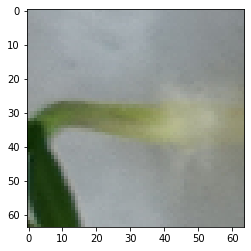

clssify as: 1 [[0.00219285 0.55872834 0.43907878]]


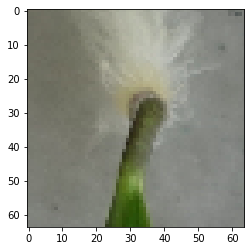

clssify as: 1 [[0.00211962 0.57831234 0.419568  ]]


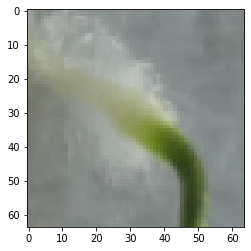

clssify as: 1 [[0.00204501 0.59420353 0.40375146]]


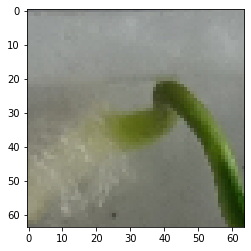

clssify as: 1 [[0.00240735 0.61390764 0.38368496]]


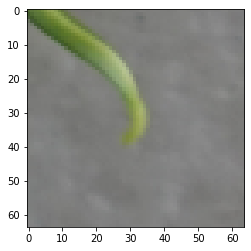

clssify as: 1 [[0.00202176 0.568539   0.42943928]]


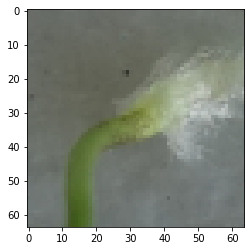

clssify as: 1 [[0.00194818 0.58422315 0.41382867]]


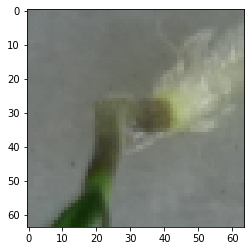

clssify as: 1 [[0.00201588 0.5591265  0.43885764]]


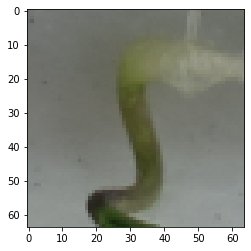

clssify as: 1 [[0.00212677 0.54845726 0.44941592]]


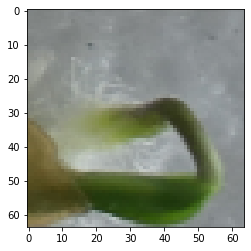

clssify as: 1 [[0.00230654 0.5641841  0.43350935]]


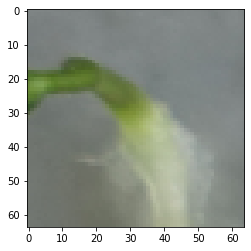

clssify as: 1 [[0.00213378 0.5804376  0.41742858]]


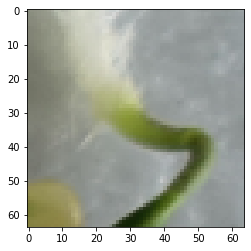

clssify as: 1 [[0.00171323 0.61460775 0.38367906]]


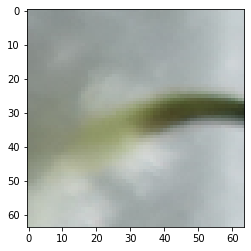

clssify as: 1 [[0.00199968 0.5858504  0.41214994]]


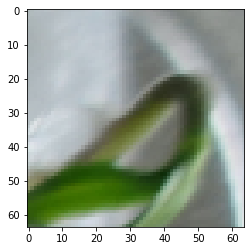

clssify as: 1 [[0.00258874 0.58714205 0.41026914]]


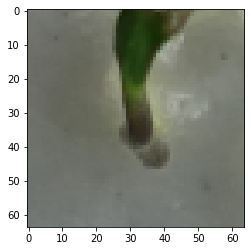

clssify as: 1 [[0.00198889 0.61116666 0.3868444 ]]


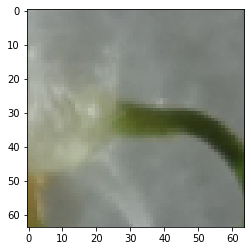

clssify as: 1 [[0.00282527 0.5120107  0.48516402]]


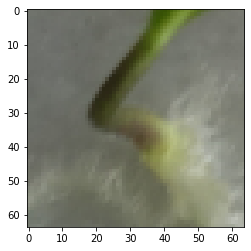

clssify as: 1 [[0.00257158 0.5233307  0.47409767]]


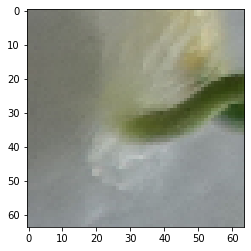

clssify as: 1 [[0.00255965 0.5852876  0.41215277]]


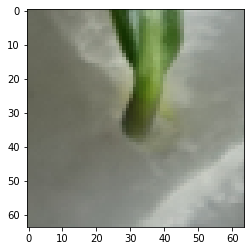

clssify as: 1 [[0.0020127  0.59409785 0.40388942]]


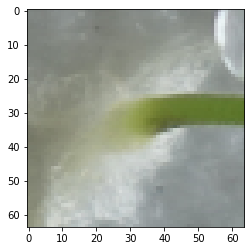

clssify as: 1 [[0.0024804 0.5420016 0.455518 ]]


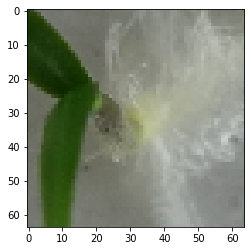

clssify as: 1 [[0.00298855 0.50229144 0.49472   ]]


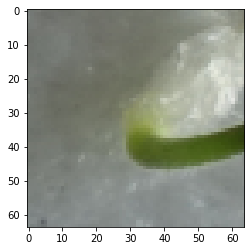

clssify as: 1 [[0.00227147 0.54618347 0.451545  ]]


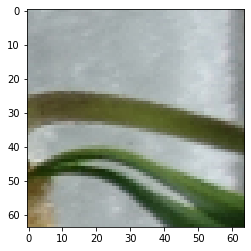

clssify as: 1 [[0.00222837 0.56788415 0.42988747]]


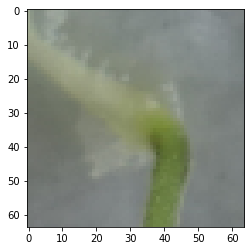

clssify as: 1 [[0.00243555 0.54931563 0.44824886]]


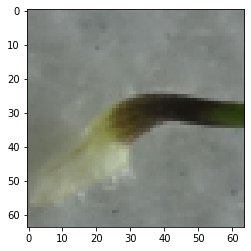

clssify as: 1 [[0.00213116 0.5849116  0.4129573 ]]


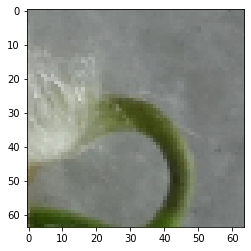

clssify as: 1 [[0.00297554 0.53954685 0.4574776 ]]


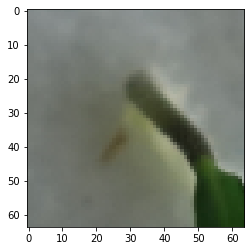

clssify as: 1 [[0.00227189 0.5790376  0.41869056]]


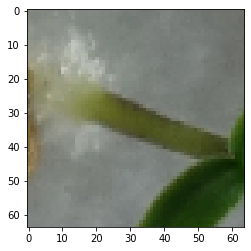

clssify as: 1 [[0.00233672 0.5414124  0.4562509 ]]


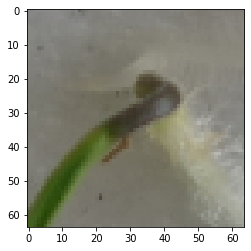

clssify as: 1 [[0.0021512  0.55046517 0.44738364]]


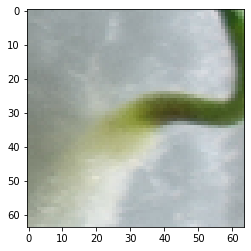

clssify as: 1 [[0.00215638 0.5708513  0.4269923 ]]


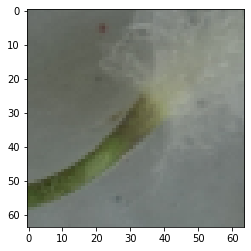

clssify as: 1 [[0.00193445 0.5891295  0.40893605]]


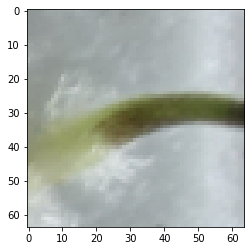

clssify as: 1 [[0.00295948 0.5040426  0.49299785]]


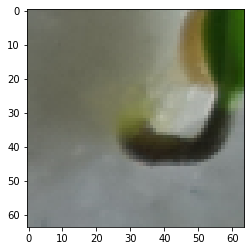

clssify as: 1 [[0.00291281 0.51627105 0.48081607]]


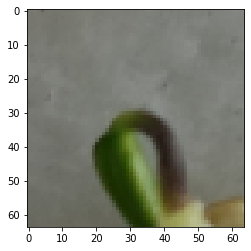

clssify as: 1 [[0.00213409 0.5425251  0.45534074]]


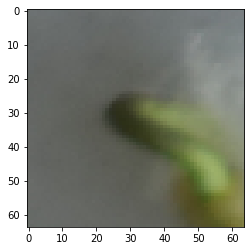

clssify as: 1 [[0.00221492 0.5474945  0.45029065]]


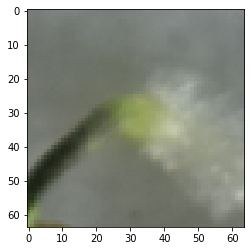

clssify as: 1 [[0.00218458 0.52738273 0.47043273]]


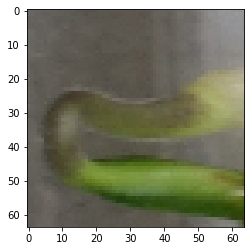

clssify as: 1 [[0.00244265 0.5377041  0.4598532 ]]


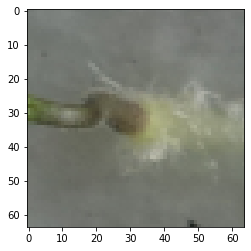

clssify as: 1 [[0.00226143 0.58083475 0.41690385]]


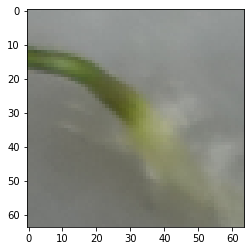

clssify as: 1 [[0.00295129 0.52116895 0.47587982]]


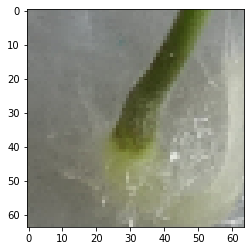

clssify as: 1 [[0.00273072 0.55124384 0.4460255 ]]


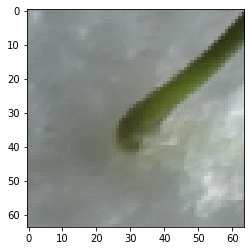

clssify as: 1 [[0.0019428  0.6235867  0.37447047]]


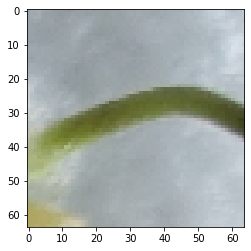

clssify as: 1 [[0.00284761 0.5158943  0.48125815]]


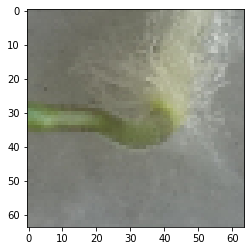

clssify as: 1 [[0.00250679 0.5630569  0.43443632]]


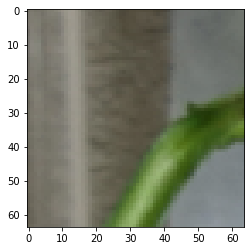

clssify as: 1 [[0.0020992 0.5423719 0.4555289]]


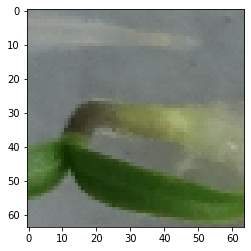

clssify as: 1 [[0.00221434 0.56899273 0.42879292]]


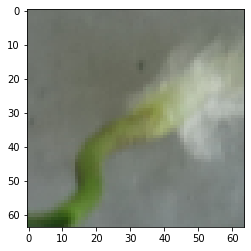

clssify as: 1 [[0.00214277 0.59296304 0.40489417]]


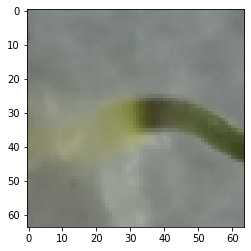

clssify as: 1 [[0.00257425 0.54289997 0.4545258 ]]


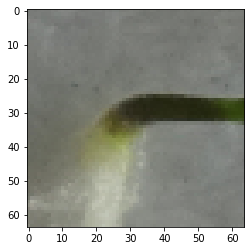

clssify as: 1 [[0.00203394 0.59385264 0.40411344]]


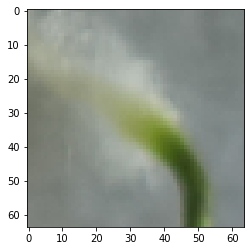

clssify as: 1 [[0.00236778 0.5806903  0.4169419 ]]


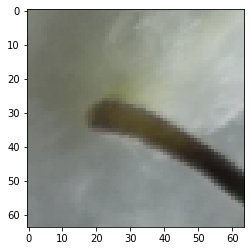

clssify as: 1 [[0.00226702 0.5708806  0.42685238]]


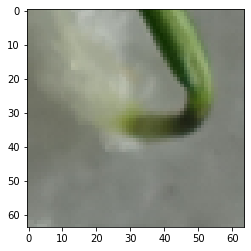

clssify as: 1 [[0.00219808 0.5240676  0.47373438]]


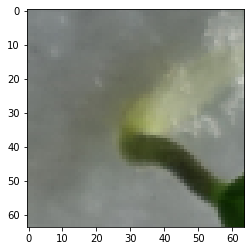

clssify as: 1 [[0.00214614 0.5839047  0.41394922]]


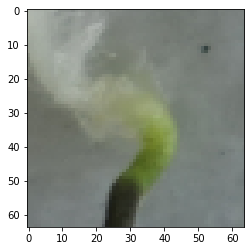

clssify as: 1 [[0.0020414  0.61264575 0.38531286]]


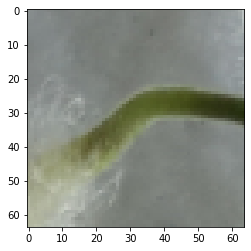

clssify as: 1 [[0.00224572 0.5554749  0.44227946]]


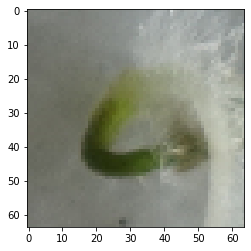

clssify as: 1 [[0.00282526 0.52352226 0.47365245]]


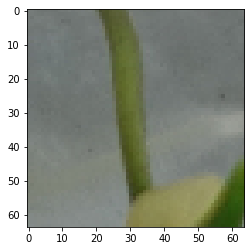

clssify as: 1 [[0.00237634 0.5560481  0.44157553]]


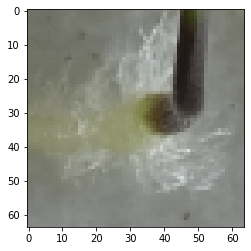

clssify as: 1 [[0.00213759 0.5898209  0.4080415 ]]


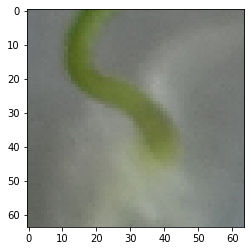

clssify as: 1 [[0.00233863 0.5623827  0.43527868]]


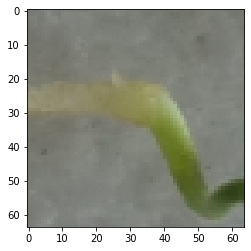

clssify as: 1 [[0.00220352 0.5655253  0.4322712 ]]


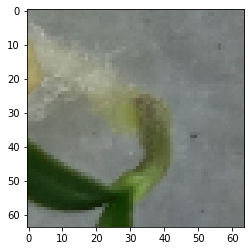

clssify as: 1 [[0.00198426 0.5850632  0.4129525 ]]


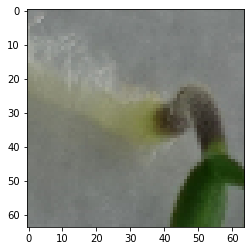

clssify as: 1 [[0.00176852 0.58697915 0.41125232]]


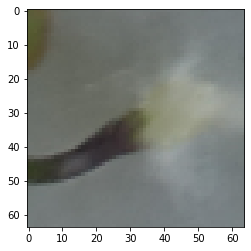

clssify as: 1 [[0.00193505 0.5996271  0.3984379 ]]


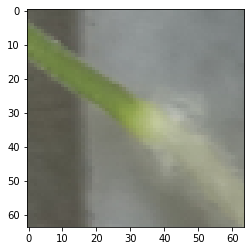

clssify as: 1 [[0.00246553 0.5610823  0.43645212]]


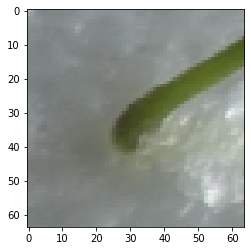

clssify as: 1 [[0.00241407 0.5792775  0.41830835]]


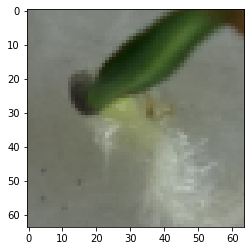

clssify as: 1 [[0.0033118  0.5277351  0.46895304]]


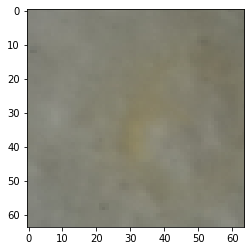

clssify as: 1 [[0.00205341 0.5819487  0.41599792]]


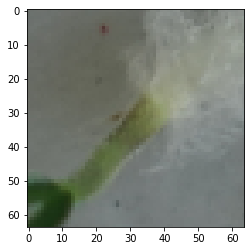

clssify as: 1 [[0.00256559 0.54166114 0.4557732 ]]


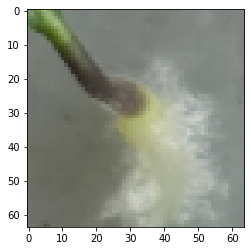

clssify as: 1 [[0.00269137 0.57646894 0.42083967]]


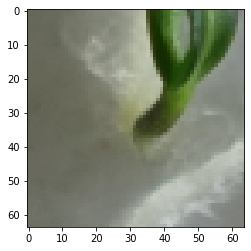

clssify as: 1 [[0.00249008 0.5669707  0.43053922]]


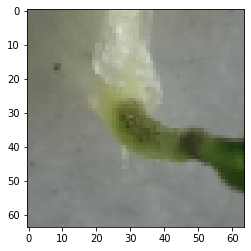

clssify as: 1 [[0.00288154 0.51463753 0.48248097]]


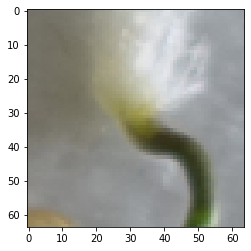

clssify as: 1 [[0.00239188 0.5599008  0.43770728]]


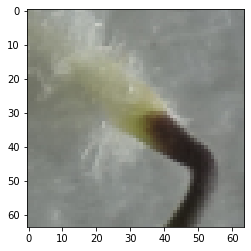

clssify as: 1 [[0.0022234  0.57646376 0.4213128 ]]


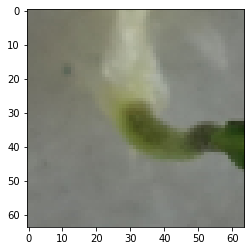

clssify as: 1 [[0.00204158 0.6025463  0.39541215]]


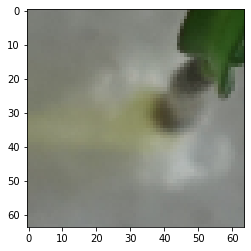

clssify as: 1 [[0.00217411 0.5686045  0.42922133]]


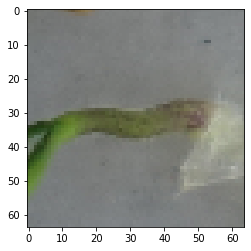

clssify as: 1 [[0.00236263 0.56559795 0.43203947]]


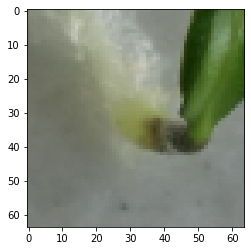

clssify as: 1 [[0.00205679 0.55039656 0.4475466 ]]


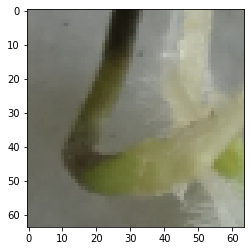

clssify as: 1 [[0.00214003 0.5848824  0.41297758]]


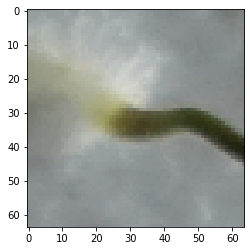

clssify as: 1 [[0.00240537 0.54947805 0.44811657]]


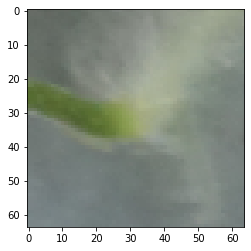

clssify as: 1 [[0.00257692 0.5360953  0.46132773]]


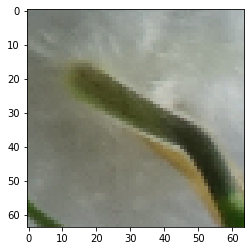

clssify as: 1 [[0.0022264 0.5842574 0.4135162]]


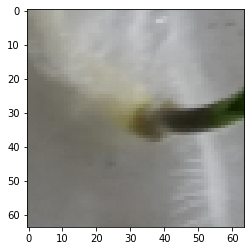

clssify as: 1 [[0.0023902  0.5875594  0.41005042]]


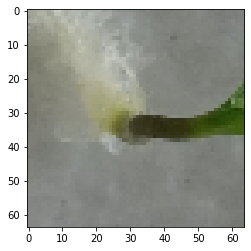

clssify as: 1 [[0.00233663 0.5736277  0.4240357 ]]


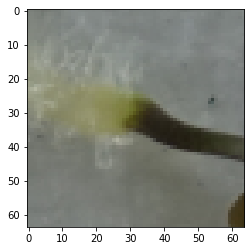

clssify as: 1 [[0.00220238 0.5883805  0.4094171 ]]


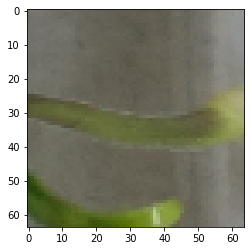

clssify as: 1 [[0.00277018 0.5295857  0.4676441 ]]


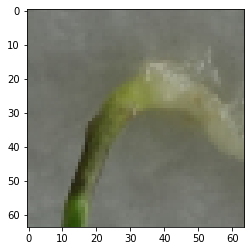

clssify as: 1 [[0.00215979 0.57624924 0.42159095]]


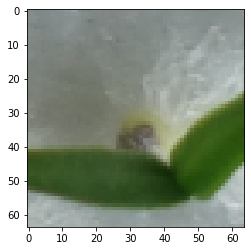

clssify as: 1 [[0.00213876 0.5780764  0.41978484]]


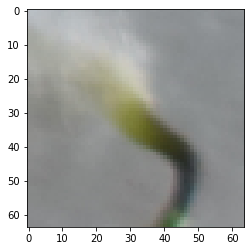

clssify as: 1 [[0.00243778 0.57575    0.42181227]]


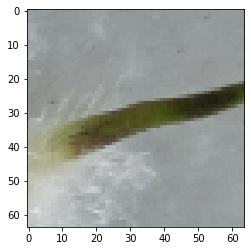

clssify as: 1 [[0.00262692 0.53768367 0.45968944]]


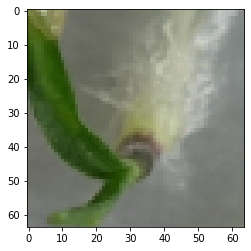

clssify as: 1 [[0.00287369 0.4996886  0.49743778]]


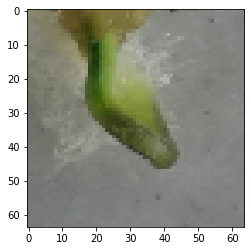

clssify as: 1 [[0.00271039 0.5303576  0.466932  ]]


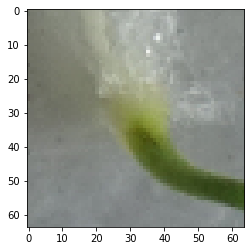

----------------------------------



In [0]:
for i in os.listdir('/content/seed_dataset/test'):
  print(i, '\n')
  if i == 'pos':
    continue
  for j in os.listdir(os.path.join('/content/seed_dataset/test', i)):
    img = image.load_img(os.path.join('/content/seed_dataset/test', i, j))
    img = image.img_to_array(img)
    img = np.expand_dims(img/255.0, axis = 0)
    result = model.predict(img)
    if test_set.class_indices[i] == result.argmax():
      print('clssify as:', result.argmax(), result)
      plt.imshow(img[0])
      plt.show()
  print('----------------------------------\n')


In [0]:
result.argmax()

2

In [0]:
k = tf.where(y_pred != test_set.classes)
k[:,0]

<tf.Tensor: shape=(33,), dtype=int64, numpy=
array([ 151,  163,  173,  190,  338,  465,  538,  631,  768, 1086, 1310,
       1319, 1446, 1501, 1518, 1570, 1605, 1635, 1647, 1655, 1667, 1883,
       2013, 2123, 2216, 2375, 2421, 2458, 2469, 2498, 2655, 2685, 2732])>

In [0]:
for i in range(1, 26):
  path = '/content/gdrive/My Drive/Colab Notebooks//predict/' + str(i) + '.png'
  test_image = image.load_img(path, target_size = (224, 224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image/255.0, axis = 0)
  result = model.predict(test_image)
  print(i)
  print(result)
  print('Probability : ',max(result[0]))

  if result[0][0] == max(result[0]):
    prediction = 'neg'
  elif result[0][1] == max(result[0]):
    prediction = 'none'
  elif result[0][2] == max(result[0]):
    prediction = 'pos'
  else:
    prediction = 'error'
  print(f'Prediction: {prediction}')

  test = io.imread(path)
  print('Original : ', test.shape)
  test = cv2.resize(test, (224,224) ,interpolation = cv2.INTER_AREA)
  print('Resize : ', test.shape)
  plt.imshow(test)
  plt.show()

FileNotFoundError: ignored